In [31]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import warnings

from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LogNorm
from matplotlib import animation

from scipy.optimize import fmin, minimize, OptimizeResult
from collections import defaultdict
from itertools import zip_longest
from functools import partial

from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import DecisionBoundaryDisplay

from copy import deepcopy

## <span style="color:blue">Implementation (Students do)</span>
<hr/>

### Methods
You will implement five optimization algorithms (descriptions available [here](https://web.archive.org/web/20230121055130/https://ruder.io/optimizing-gradient-descent/index.html)).
- Gradient descent (`gd`)
- MirrorDescent (`mirrD`)
- Accelerated gradient method (`acc`)
- Adaptive gradient method (`adagrad`)
- Adaptive moment estimation (`adam`)

The last is a very common optimizer used in practical applications -- possibly the most common in the world.

In addition, you will also implement a method for mirrorstep for the entropy regularizer and the ell_2 regularizer `mirrorstep_entropy/ell_2`. The latter of which you will use for the mirror descent algorithm and may also use for the accelerated method implementation.
Make note of the function headers: `def gd(func, x, lr, num_iters, grad):`.
- `func`: [type: function] The loss function. Takes in a point of type np.ndarray (n,) for some n and returns a float representing the value of the function at that point.
- `x`: [type: np.ndarray (n,)] The starting point of the optimization.
- `lr`: [type: real] Learning rate.
- `num_iters`: [type: int] The number of iterations of the optimization method to run.
- `grad`: [type: function] The gradient of the loss function. Takes in a point of type np.ndarray (n,) and returns an np.ndarray (n,) representing the gradient of the function at that point.

Each function will need to return a `np.ndarray` containing all the iterates over the course of the optimization.


In [44]:
#takes as input an x which is on the n-dimensional unit simplex, 
#lr is a FIXED SCALAR Learning Rate (not a schedule function like the rest of the problem) and grad is a vector which 
#returns gradient of a given function at point x. Return the next iterate of the mirror step.
def mirrorstep_entropy(x, lr, grad):
    g = grad(x)
    deltaH = lambda x : np.log(x + 1e-10)
    h = lambda x : np.sum(np.dot(x, np.log(x + 1e-10)) - x)
    objective_func = lambda y: float((np.dot(np.array([lr*i for i in g]), y) + (h(y) - h(x) - np.dot(deltaH(x), y - x))))
    x_next = minimize(objective_func, np.zeros(x.shape)).x
    return x_next
# def mirrorstep_entropy(x, lr, grad):
#     g = grad(x)
#     deltaH = lambda x : np.log(x)
#     h = lambda x : np.sum(np.dot(x, np.log(x)) - x)
#     print(lambda y: -1*(np.dot(lr*g, y) + (h(y) - h(x) - np.dot(deltaH(x), y - x))), np.zeros(x.shape))
#     x_next = minimize(lambda y: -1*(np.dot(lr*g, y) + (h(y) - h(x) - np.dot(deltaH(x), y - x))), np.zeros(x.shape)).x[0]
#     return x_next
#same as above except x lies in R^n inside of the unit simplex.
def mirrorstep_ell_2(x, lr, grad):
    g = grad(x)
    deltaH = lambda x : x
    h = lambda x : np.sum(x**2/2)
#     print("x :", x)
#     print("shape of x :", np.shape(x))
#     print("grad of x :",grad(x))
#     print("dot of gradient of x*lr and theta :",np.dot(lr*g, np.zeros(x.shape)))
#     print("h of theta :", h(np.zeros(x.shape)))
#     print("h of x :",h(x))
#     print("last term:", np.dot(deltaH(x), np.zeros(x.shape) - x))
    x_next = minimize(lambda theta: float((np.dot(lr*g, theta) + (h(theta) - h(x) - np.dot(deltaH(x), theta - x)))), np.zeros(x.shape)).x
    return x_next

def gd(func, x, lr, num_iters, grad):
    iterates = []
    iterates.append(deepcopy(x))
    for itr in range(num_iters):
        update = -1*lr*grad(x) #change the update function
        x += update
        iterates.append(deepcopy(x))
    return np.array(iterates)

def mirrorD(func, x, lr, num_iters, grad):
    iterates = []
    iterates.append(deepcopy(x))
    for itr in range(num_iters):
        x = mirrorstep_ell_2(x, lr, grad)
        iterates.append(deepcopy(x))
    return np.array(iterates)
    

#we will not use a learning rate but rather use a parameter L which denotes the Lipshitz constant of the function to be optimized. 
# Use the stepsize/learning rates you got from the PDF part of the problem. Return the y sequence of iterates
def acc(func, x, L, num_iters, grad):
    iterates = []
    y = x - (1/L)*grad(x)
    z = np.zeros(x.shape)
    iterates.append(deepcopy(x))
    for itr in range(num_iters):
        x = np.array([(2/(itr + 2))*i for i in z]) + np.array([(1 - (2/(itr + 2)))*i for i in y])
        y = x - np.array([(1/L)*i for i in grad(x)])
        z = mirrorstep_ell_2(z, (itr + 2)/(2*L), grad)
        iterates.append(deepcopy(x))
    return np.array(iterates)

def adagrad(func, x, lr, num_iters, grad, eps=1e-5):
    sq_grad_sums = 0
    iterates = []
    iterates.append(deepcopy(x))
    for it in range(num_iters):
        sq_grad_sums = grad(x)**2
        alpha = lr / (eps + np.sqrt(sq_grad_sums))
        # x_opt -= lr * grad_x / (np.sqrt(grad_squared) + eps)
        x -= alpha*grad(x)
        iterates.append(deepcopy(x))
    return np.array(iterates)


def adam(func, x, lr, num_iters, grad, beta1=0.9, beta2=0.999, eps=1e-5):
    
    rList = [x]
    m = np.zeros(x.shape)
    v = np.zeros(x.shape)
    for i in range(num_iters):
        ga = grad(x)
        
        m = beta1*m + (1-beta1)*ga
        v = beta2*v + (1-beta2)*(ga**2)

        mnorm = m/(1 - np.power(beta1, i + 1))
        vnorm = v/(1 - np.power(beta2, i + 1))

        x -= lr * mnorm / (np.sqrt(vnorm) + eps)

        rList.append(x)       
    
    return np.array(rList)

# extension #2

def line_search(func, x, y):
    return minimize(lambda z: func(x + np.dot(z, (y - x))), np.zeros(np.shape(x))).x

def minimum_enclosing_ball(xA, RA, xB, RB):
    d2 = (np.linalg.norm(xA - xB)**2)
    RA2 = RA**2
    RB2 = RB**2

    if d2 >= abs(RA2 - RB2):
        c = 0.5 * (xA + xB) - ((RA2 - RB2) / (2 * d2)) * (xA - xB)
        R = np.sqrt(RB2 - (d2 + RB2 - RA2)**2 / (4 * d2))
    elif d2 < RA2 - RB2:
        c = xB
        R = RB
    else:
        c = xA
        R = RA

    return c, R
    
def geoD(f, x, alpha, num_iters, grad_f):
    
    iterates = []
    iterates.append(deepcopy(x))
    
    x_plus = line_search(f, x, x - grad_f(x))
    c = x - np.array([(alpha**-1)*i for i in grad_f(x)])
    R2 = (np.linalg.norm(grad_f(x))**2)*(alpha**-2 - 2/alpha) * ((f(x) - f(x_plus))**-1)
    
    for i in range(num_iters):
        # Combining step
        old_k_plus = x_plus
        x = line_search(f, x_plus, c)
        
        # Gradient step
        x_plus = line_search(f, x, x - grad_f(x))
        
        # Ellipsoid step
        x_A = x - np.array([(alpha**-1)*i for i in grad_f(x)])
        R2_A = (np.linalg.norm(grad_f(x))**2)/(alpha**2) - (2/alpha) * ((f(x) - f(x_plus)))
        
        x_B = c
        R2_B = R2 - (2/alpha)*(f(old_k_plus) - f(x_plus))
        
        # Minimum enclosing ball of the intersection of two balls
        c, R2 = minimum_enclosing_ball(x_A, R2_A, x_B, R2_B)
        
        iterates.append(deepcopy(x))
        
    return iterates

h = lambda x : np.sum(np.dot(x, np.log(x)) - x)
deltaH = lambda x : np.log(x)
# print(m(np.array([1,1,1,1,1,1,1,1,1])))
# print(n(np.array([1,1,1,1,1,1,1,1,1])))
# print(np.dot(np.array([1,1,1,1,1,1,1,1,1]), np.array([1,1,1,1,1,1,1,1,1])))
# print(type(np.zeros(np.array([1,1,1,1,1,1,1,1,1]).shape)))
g = np.array([1,1,1,1,1,1,1,1,1])
x = np.array([1,1,1,1,1,1,1,1,1])
lr = 0.1

objective_func = lambda y: float(-1*(np.dot(lr*g, y) + (h(y) - h(x) - np.dot(deltaH(x), y - x))))
print(type(objective_func(np.array([1,1,1,1,1,1,1,1,1]))))
print(type(0.0001))



<class 'float'>
<class 'float'>


## Testing your code
We are not providing much structure here, but now is a good time to make sure your optimization methods are working well. The cell below tests your gradient descent method on the function $f(x)=x^2$.

In [45]:
x_squared_fval = lambda x: x**2
x_squared_grad = lambda x: 2*x
iterates = geoD(x_squared_fval,3,0.3,100,x_squared_grad)
res=[(i,x,x_squared_fval(x)) for (i,x) in enumerate(iterates)]
print([x[2] for x in res])

TypeError: 'int' object is not iterable

## <span style="color:red">Submission: Challenge</span>
<span style="color:red">In this part, you will implement the lambda functions for the functional value and the gradient function for logistic regression function given a data matrix X and output vector y. Finally you will run the above algorithms that you implemented for a classification dataset. </span>

In [46]:
#1/n \sum_i y_i log(1/(1+e^(-x_i^t w)) + (1-y_i) log(1-1/(1+e^(-x_i^t w))
def logistic_regression_fval(X,y,w):

    n = X.shape[0]
    h = 1.0 / (1.0 + np.exp(-np.dot(X, w)))
    f = (-1.0 / n) * np.sum(y * np.log(h + 1e-10) + (1 - y) * np.log(1 - h + 1e-10))
    return f

def logistic_regression_grad(X,y,w):
    
    n = X.shape[0]
    h = 1.0 / (1.0 + np.exp(-np.dot(X, w)))
    grad = (1.0 / n) * np.dot(X.T, (h - y))
    return grad

[3.7025253400899634, 3.639869732767588, 3.577760944296779, 3.516207319415619, 3.45522459781892, 3.394823726414862, 3.33502064622115, 3.275825135910391, 3.2172520639614604, 3.1593150838927144, 3.1020317444875443, 3.0454073921933262, 2.9894646255259754, 2.934208126261796, 2.879649923064331, 2.8258009417914884, 2.77266755527171, 2.7202589618849338, 2.6685845245944138, 2.6176496012494463, 2.5674621480552, 2.5180258655748395, 2.469343538025231, 2.421414089620126, 2.3742484860514352, 2.3278431599056635, 2.282204603991092, 2.2373320755937773, 2.1932286826626433, 2.149893797114072, 2.1073331837816274, 2.065554071915384, 2.0245556524752244, 1.984339769858029, 1.9449160919184594, 1.9062876917286893, 1.8684634351891654, 1.831446888625963, 1.7952445939606516, 1.7598643045295725, 1.7253091553825757, 1.691581491982188, 1.6586800849485164, 1.6266016919680524, 1.5953389758634418, 1.5648829551796852, 1.5352270634316108, 1.5063573448278715, 1.4782592715354546, 1.4509226186131714, 1.4243319323416477, 1.3

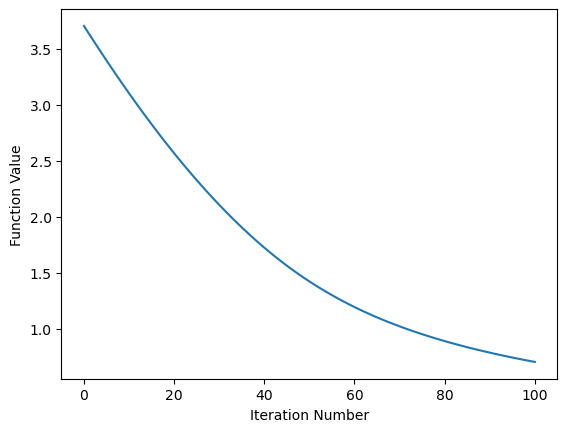

In [47]:
#Logistic Regression Dataset
data=datasets.load_breast_cancer()
X=data.data
scaler=StandardScaler()
scaler.fit(X)
X=scaler.transform(X)
y=data.target
warnings.filterwarnings('ignore')
iterates = mirrorD(lambda w:logistic_regression_fval(X,y,w),np.random.randn(X.shape[1]),0.01,100,lambda w:logistic_regression_grad(X,y,w))
res=[(i,w,logistic_regression_fval(X,y,w)) for (i,w) in enumerate(iterates)]
print([x[2] for x in res])

#Plot function value decrease over all iterations
plt.plot([x[0] for x in res],[x[2] for x in res])
plt.xlabel('Iteration Number')
plt.ylabel('Function Value')
plt.show()

[2.083952586356855, 2.056254032366078, 2.029051813381461, 2.002329255543537, 1.9760704591026015, 1.9502606445906834, 1.9248863518167227, 1.8999355293597278, 1.8753974865288652, 1.8512628142484235, 1.8275232677693458, 1.804171597134397, 1.7812014099585758, 1.7586070400402025, 1.7363833912671869, 1.7145258289788914, 1.693030084014367, 1.671892129971674, 1.6511081266718572, 1.6306743355000992, 1.610587045186371, 1.5908425428790605, 1.5714370601528431, 1.55236672899824, 1.5336275827323378, 1.5152155272961574, 1.4971263407399316, 1.4793556764016114, 1.4618990722546816, 1.4447519647585914, 1.4279097054483867, 1.411367578575277, 1.3951208144366365, 1.379164620710127, 1.3634941686885456, 1.3481046356313753, 1.3329911824101248, 1.3181489878404054, 1.3035732388362213, 1.2892591394535071, 1.2752019159796968, 1.2613968223967862, 1.2478391464610858, 1.2345242125467524, 1.2214474006437201, 1.2086041461432668, 1.195989935696369, 1.1836003378171378, 1.1714309937697382, 1.1594776230977983, 1.1477360436

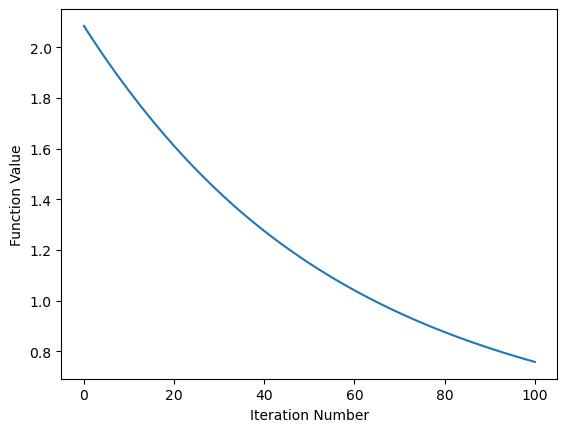

In [48]:
iterates = gd(lambda w:logistic_regression_fval(X,y,w),np.random.randn(X.shape[1]),0.01,100,lambda w:logistic_regression_grad(X,y,w))
res=[(i,w,logistic_regression_fval(X,y,w)) for (i,w) in enumerate(iterates)]
print([x[2] for x in res])

#Plot function value decrease over all iterations
plt.plot([x[0] for x in res],[x[2] for x in res])
plt.xlabel('Iteration Number')
plt.ylabel('Function Value')
plt.show()


[1.2657756782204548, 0.6933103197132838, 0.6932129107894036, 0.6932129110603781, 0.6932129108735611, 0.6932129106753532, 0.6932129106732408, 0.6932129106722075, 0.693212910767051, 0.6932129110924942, 0.6932129107514582, 0.6932129107698508, 0.6932129107511216, 0.6932129106639418, 0.6932129107522358, 0.693212911103294, 0.6932129106954406, 0.6932129106392703, 0.6932129107517585, 0.6932129107685091, 0.6932129108824309, 0.6932129107689097, 0.6932129107606999, 0.6932129106949876, 0.6932129111060554, 0.6932129107692788, 0.6932129111077027, 0.6932129107310296, 0.6932129110724277, 0.6932129106737376, 0.6932129111017621, 0.6932129108990971, 0.693212910695767, 0.6932129106467643, 0.693212910751876, 0.6932129107519664, 0.6932129107593685, 0.6932129107964299, 0.6932129107517528, 0.6932129107532746, 0.6932129108828928, 0.6932129106970556, 0.6932129107618044, 0.6932129107282774, 0.693212910694761, 0.6932129111161438, 0.6932129107697191, 0.6932129106878039, 0.6932129107304745, 0.6932129111080616, 0.69

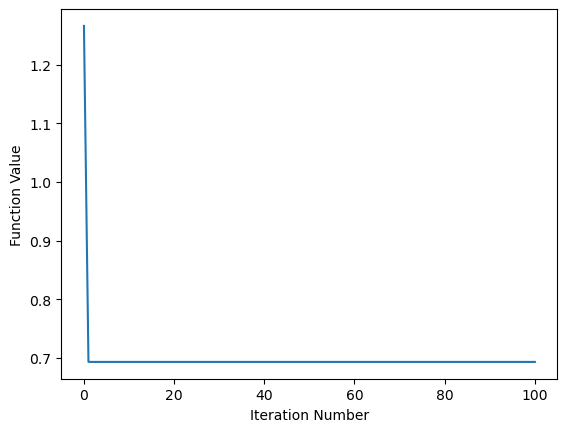

In [52]:
iterates = geoD(lambda w:logistic_regression_fval(X,y,w),np.random.randn(X.shape[1]),0.0001,100,lambda w:logistic_regression_grad(X,y,w))
res=[(i,w,logistic_regression_fval(X,y,w)) for (i,w) in enumerate(iterates)]
print([x[2] for x in res])

#Plot function value decrease over all iterations
plt.plot([x[0] for x in res],[x[2] for x in res])
plt.xlabel('Iteration Number')
plt.ylabel('Function Value')
plt.show()

[3.422632931324239, 0.6931471803599452, 1.4756274232782254, 0.9448798199873915, 0.6879537571469266, 0.6474812792737199, 0.6025701715020625, 0.5518835525280485, 0.5260739640062129, 0.5150211705046008, 0.4839463999918763, 0.5009734536236291, 0.411709410117004, 0.5665411476597554, 0.6795805244056705, 0.526073922730374, 0.6070083723966729, 0.5504372721157474, 0.4811049847929057, 0.36418130168069096, 0.4182335673652206, 0.34146137388712267, 0.3497908204140392, 0.44356626663885795, 0.3237378010034144, 0.3237383151716532, 0.3976155191056052, 0.32373779856491325, 0.32373779856489243, 0.40968004313040235, 0.3622658628561727, 0.4856064531111889, 0.5655114032677978, 0.612372233846269, 0.5566924463517301, 0.5197956871665181, 0.4451205484263519, 0.4140220717474969, 0.42758252696218185, 0.4451005106026032, 0.40761007679548494, 0.4060009460536551, 0.4349671876463126, 0.4838376580986361, 0.3639710295018444, 0.364205023126789, 0.35713582700105106, 0.35656930867079994, 0.40467223393304536, 0.37858528797

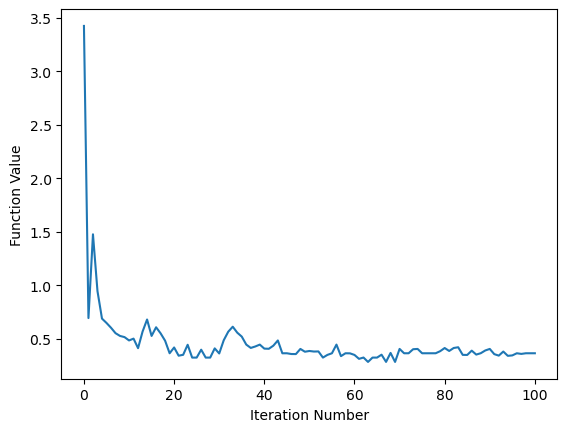

In [42]:
iterates = acc(lambda w:logistic_regression_fval(X,y,w),np.random.randn(X.shape[1]),0.001,100,lambda w:logistic_regression_grad(X,y,w))
res=[(i,w,logistic_regression_fval(X,y,w)) for (i,w) in enumerate(iterates)]
print([x[2] for x in res])

#Plot function value decrease over all iterations
plt.plot([x[0] for x in res],[x[2] for x in res])
plt.xlabel('Iteration Number')
plt.ylabel('Function Value')
plt.show()

[0.048729305992126104, 0.048729305992126104, 0.048729305992126104, 0.048729305992126104, 0.048729305992126104, 0.048729305992126104, 0.048729305992126104, 0.048729305992126104, 0.048729305992126104, 0.048729305992126104, 0.048729305992126104, 0.048729305992126104, 0.048729305992126104, 0.048729305992126104, 0.048729305992126104, 0.048729305992126104, 0.048729305992126104, 0.048729305992126104, 0.048729305992126104, 0.048729305992126104, 0.048729305992126104, 0.048729305992126104, 0.048729305992126104, 0.048729305992126104, 0.048729305992126104, 0.048729305992126104, 0.048729305992126104, 0.048729305992126104, 0.048729305992126104, 0.048729305992126104, 0.048729305992126104, 0.048729305992126104, 0.048729305992126104, 0.048729305992126104, 0.048729305992126104, 0.048729305992126104, 0.048729305992126104, 0.048729305992126104, 0.048729305992126104, 0.048729305992126104, 0.048729305992126104, 0.048729305992126104, 0.048729305992126104, 0.048729305992126104, 0.048729305992126104, 0.0487293

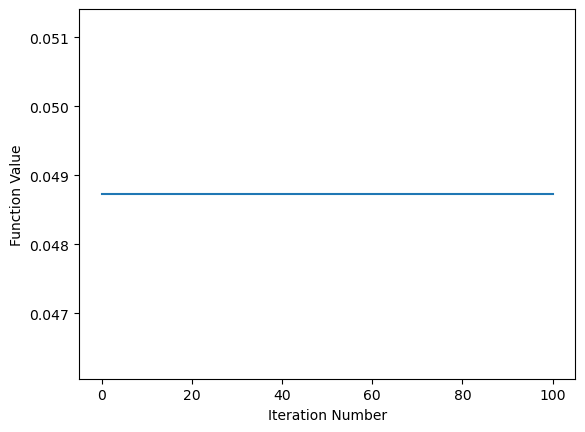

In [53]:
iterates = adam(lambda w:logistic_regression_fval(X,y,w),np.random.randn(X.shape[1]),1,100,lambda w:logistic_regression_grad(X,y,w))
res=[(i,w,logistic_regression_fval(X,y,w)) for (i,w) in enumerate(iterates)]
print([x[2] for x in res])

#Plot function value decrease over all iterations
plt.plot([x[0] for x in res],[x[2] for x in res])
plt.xlabel('Iteration Number')
plt.ylabel('Function Value')
plt.show()

[1.6334761232928383, 1.5564281533469817, 1.4821386628678088, 1.410619293466392, 1.3418882939625159, 1.275963539272783, 1.2128492077112938, 1.1525303855145448, 1.0949853863431391, 1.0402009524231945, 0.988173607458446, 0.9388987295049477, 0.8923588161926526, 0.8485217036401009, 0.8073530288129995, 0.7686429323081639, 0.7323423858065654, 0.6983549832365383, 0.6665486909426228, 0.6369156517440356, 0.6093795289224371, 0.5838072981448508, 0.5596291993727899, 0.5366878325563158, 0.5149163737866892, 0.49425840279362204, 0.4746654716411551, 0.4560947427372451, 0.4385070372343292, 0.42183301981899796, 0.40598861530998814, 0.3909406170294277, 0.3766553285017641, 0.3630990293994666, 0.3502381254016158, 0.3380393627143867, 0.32647008251607706, 0.31549847028842887, 0.3050937490273513, 0.2952262638064531, 0.2858670147534614, 0.27690064953960897, 0.26829740509005345, 0.26004019719467086, 0.25211906912371285, 0.2445221531725734, 0.2372325068267183, 0.23024392784383188, 0.22354638114194034, 0.217114407

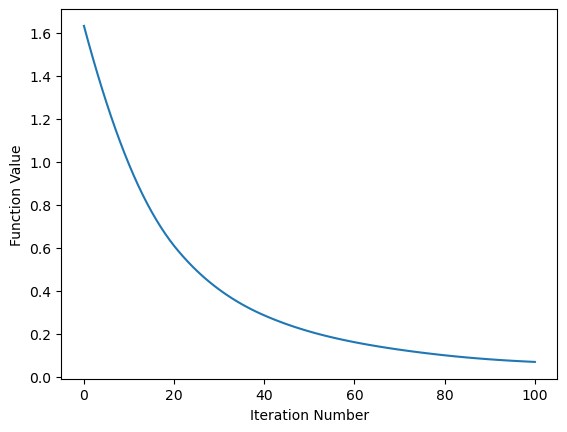

In [40]:
iterates = adagrad(lambda w:logistic_regression_fval(X,y,w),np.random.randn(X.shape[1]),0.01,100,lambda w:logistic_regression_grad(X,y,w))
res=[(i,w,logistic_regression_fval(X,y,w)) for (i,w) in enumerate(iterates)]
print([x[2] for x in res])

#Plot function value decrease over all iterations
plt.plot([x[0] for x in res],[x[2] for x in res])
plt.xlabel('Iteration Number')
plt.ylabel('Function Value')
plt.show()

In [ ]:
Run the above code for all the different algorithms and report the convergence behavior of all the algorithms. Add the plots of the function value decrease over all iterates to a PDF file (or add different cells for the run of each algorithm and the plotting and you can just use the PDF of the jupyter notebook. )